In [8]:
# Our engines
import numpy as np
import scipy.integrate

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

rcrc = {'grid': True,
      'axisbelow': True,
      'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18}
sns.set_context('notebook', rc=rcrc)
sns.set_style('whitegrid', rc=rcrc)

import matplotlib
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

plt.rcParams['text.usetex'] = False

In [9]:
colors = np.array([[   0.5,    0.5,    0.5],   #  1) gray
                   [0.3010, 0.7450, 0.9330],   #  2) cyan
                   [     0, 0.4470, 0.7410],   #  3) blue
                   [     0, 0.2235, 0.3705],   #  4) dark blue
                   [0.4940, 0.1840, 0.5560],   #  5) purple
                   [0.8500, 0.3250, 0.0980],   #  6) orange
                   [0.9290, 0.6940, 0.1250],   #  7) yellow/gold
                   [0.5882, 0.2941,      0],   #  8) brown
                   [0.9500, 0.0800, 0.0980],   #  9) red
                   [0.9525, 0.1170, 0.5520],   # 10) pink-magenta
                   [0.6350, 0.0780, 0.1840],   # 11) dark red
                   [0.4660, 0.6740, 0.1880],   # 12) green    
                   [     0,      0,      0]])  # 13) black

Model with Dorsal and Twist acting in both proximal and distal

In [10]:
def sna_autorepression(lvl, t,
                       T, k_in, k_out,
                       b_twi_DL, b_twi_TWI, K_DL, K_TWI,
                       n_DL, n_TWI, y_twi,
                       b_TWI, y_TWI,
                       b_prox_DL, b_prox_TWI, b_dist_TWI, b_dist_DL,
                       K_pDL, K_pTWI, K_dTWI, K_dDL, K_pclose, K_pfar, K_dclose, K_dfar,
                       K_X, n_X,
                       n_prox, n_dist, n_snap, n_snad, y_sna,
                       b_SNA, y_SNA,
                       b_x, y_x, K_SNAx, n_SNAx,
                       b_X, y_X):
    
    DL, twi, TWI, sna, SNA, x, X = lvl
    
    dDL_dt = k_in * (T-DL) - k_out * DL
    
    dtwi_dt = (b_twi_DL * (DL**n_DL  / (K_DL**n_DL + DL**n_DL))
               + b_twi_TWI * (TWI**n_TWI  / (K_TWI**n_TWI + TWI**n_TWI))
               - y_twi * twi)
    dTWI_dt = b_TWI * twi - y_TWI * TWI
    
    dsna_dt = (((K_pclose**n_snap / (K_pclose**n_snap + SNA**n_snap)) * (K_dfar**n_snad / (K_dfar**n_snad + SNA**n_snad))
               * (b_prox_DL * (DL**n_prox  / (K_pDL**n_prox + DL**n_prox)) +  b_prox_TWI * (TWI**n_prox  / (K_pTWI**n_prox + TWI**n_prox))))
               + ((K_dclose**n_snad / (K_dclose**n_snad + SNA**n_snad)) * (K_pfar**n_snap / (K_pfar**n_snap + SNA**n_snap))
                  * (K_X**n_X  / (K_X**n_X + X**n_X))
               * (b_dist_TWI * (TWI**n_dist  / (K_dTWI**n_dist + TWI**n_dist)) + b_dist_DL * (DL**n_dist  / (K_dDL**n_dist + DL**n_dist)))) 
               - y_sna * sna)
    dSNA_dt = b_SNA * sna - y_SNA * SNA
    
    dx_dt = b_x * (K_SNAx**n_SNAx  / (K_SNAx**n_SNAx + SNA**n_SNAx)) - y_x * x
    dX_dt = b_X * x - y_X * X
    
    return (dDL_dt, dtwi_dt, dTWI_dt, dsna_dt, dSNA_dt, dx_dt, dX_dt)

In [11]:
labels = [r'$\mathdefault{yw}$',#1
          r'$\mathdefault{\Delta dist 0.4}$',#2
          r'$\mathdefault{\Delta dist 1.8}$',#3
          r'$\mathdefault{\Delta dist 2.0}$',#4
          r'$\mathdefault{\Delta prox 1.3,}$' '\n' r'$\mathit{dist 2.0}$',#5
          r'$\mathdefault{\Delta prox 1.3}$',#6
          r'$\mathdefault{\Delta prox 3.0}$',#7
          r'$\mathdefault{\Delta prox 2.6}$',#8
          r'$\mathdefault{\Delta prox 4.4}$',#9
          r'$\mathdefault{dl}$ $\mathit{L > H}$',#10
          r'$\mathdefault{\Delta prox 2.6,}$' '\n' r'$\mathit{dl}$ $\mathit{L > H}$',#11
          r'$\mathdefault{sna^1}$']#12

n = len(labels)

T = 1
k_in = 1
k_out = 0.01

b_twi_DL = 1.0
b_twi_TWI = 1.0
y_twi = 1
K_DL = 1
K_TWI = 1
n_DL = 1
n_TWI = 1

b_TWI = 1.0
y_TWI = 1.0

b_prox_DL = 1.44 * np.vstack((np.array([1.0, 1.0, 1.0, 1.0, 0.1, 0.1, 0.1, 1.0, 0.0, 1.0, 1.0, 1.0]),
                             np.array([0.5, 0.5, 0.5, 0.5, 0.05, 0.05, 0.05, 0.5, 0.0, 0.5, 0.5, 0.5])))
b_prox_TWI = 0.16 * np.vstack((np.array([1.0, 1.0, 1.0, 1.0, 0.1, 0.1, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]),
                              np.array([0.5, 0.5, 0.5, 0.5, 0.05, 0.05, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5])))
b_dist_TWI = 7.2 * np.vstack((np.array([1.0, 1.0, 0.0, 0.0, 0.0, 1.13, 1.3, 1.26, 1.44, 1.0, 1.26, 1.0]),
                               np.array([0.5, 0.5, 0.0, 0.0, 0.0, 0.565, 0.65, 0.63, 0.72, 0.5, 0.63, 0.5])))
#b_dist_TWI = 7.2 * np.vstack((np.array([1.0, 0.2, 0.0, 0.0, 0.0, 1.13, 1.3, 1.26, 1.44, 1.0, 1.26, 1.0]),
#                               np.array([0.5, 0.1, 0.0, 0.0, 0.0, 0.565, 0.65, 0.63, 0.72, 0.5, 0.63, 0.5])))
b_dist_DL = 0.8 * np.vstack((np.array([1.0, 1.0, 0.0, 0.0, 0.0, 1.13, 1.3, 1.26, 1.44, 1.0, 1.26, 1.0]),
                               np.array([0.5, 0.5, 0.0, 0.0, 0.0, 0.565, 0.66, 0.63, 0.72, 0.5, 0.63, 0.5])))
                    
y_sna = 1
K_pDL = 1 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0.1, 0.1, 1])
K_pTWI = 1 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
K_dTWI = 1 * np.array([1, 8, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1])
#K_dTWI = 1 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
K_dDL = 1 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#K_pfar = 100000000000 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
#K_pclose = 100000000000 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
K_pfar = 1 * np.array([1, 1, 1, 1, 1.05, 1.05, 1.1, 1.05, 1.2, 1, 1.1, 1])
K_pclose = 0.5 * np.array([1, 1, 1, 1, 1.05, 1.05, 1.1, 1.05, 1.2, 1, 1.1, 1])  

#K_pfar = 1 * np.array([1, 1, 1, 1, 1.05, 1.05, 1.4, 1.05, 1.6, 1.05, 1.4, 1])
#K_pclose = 0.5 * np.array([1, 1, 1, 1, 1.05, 1.05, 1.4, 1.05, 1.6, 1.05, 1.4, 1])
#K_pfar = 1 * np.array([1, 1, 1, 1, 1, 1, 1.25, 1.1, 1.5, 1, 1.1, 1])
#K_pclose = 0.5 * np.array([1, 1, 1, 1, 1, 1, 1.25, 1.1, 1.5, 1, 1.1, 1])
#K_pfar = 1000000001 * np.array([1, 1, 1, 1, 1, 1, 1.25, 1.1, 1.5, 1, 1.1, 1])
#K_pclose = 100000000000.5 * np.array([1, 1, 1, 1, 1, 1, 1.25, 1.1, 1.5, 1, 1.1, 1])

K_dclose = 100000000000 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
K_dfar = 100000000000 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
#K_dfar = 1.0 * np.array([1, 100000000000, 1, 100000000000, 100000000000, 1, 1, 1, 1, 1, 1, 1])
#K_dclose = 0.5 * np.array([1, 100000000000, 1, 100000000000, 100000000000, 1, 1, 1, 1, 1, 1, 1])

K_X = 0.1
n_X = 1

n_prox = 1
n_dist = 1 * np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) #1*
n_snap = 20 * np.array([1, 1, 1, 1, 1, 1, 0.2, 1, 0.1, 1, 0.2, 1])
#n_snap = 20 * np.array([1, 1, 1, 1, 1, 1, 0.2, 0.3, 0.1, 0.85, 0.15, 1])
n_snad = 1#20

b_SNA = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
y_SNA = 1

b_x = 1
y_x = 1
K_SNAx = 0.0001
n_SNAx = 1
b_X = 1
y_X = 1

c0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
t = np.linspace(0.0, 100, 10001)

DL = np.zeros([n,len(t),2])
twi = np.zeros([n,len(t),2])
TWI = np.zeros([n,len(t),2])
sna = np.zeros([n,len(t),2])
SNA = np.zeros([n,len(t),2])
x = np.zeros([n,len(t),2])
X = np.zeros([n,len(t),2])

for j in range(2):
    for i in range(n):
        args = (T, k_in, k_out,
                b_twi_DL, b_twi_TWI, K_DL, K_TWI,
                n_DL, n_TWI, y_twi,
                b_TWI, y_TWI,
                b_prox_DL[j,i], b_prox_TWI[j,i], b_dist_TWI[j,i], b_dist_DL[j,i],
                K_pDL[i], K_pTWI[i], K_dTWI[i], K_dDL[i], K_pclose[i], K_pfar[i], K_dclose[i], K_dfar[i],
                K_X, n_X,
                n_prox, n_dist[i], n_snap[i], n_snad, y_sna,
                b_SNA[i], y_SNA,
                b_x, y_x, K_SNAx, n_SNAx,
                b_X, y_X)

        lvls = scipy.integrate.odeint(sna_autorepression, c0, t, args=args)
        DL[i,:,j], twi[i,:,j], TWI[i,:,j], sna[i,:,j], SNA[i,:,j], x[i,:,j], X[i,:,j] = lvls.transpose()

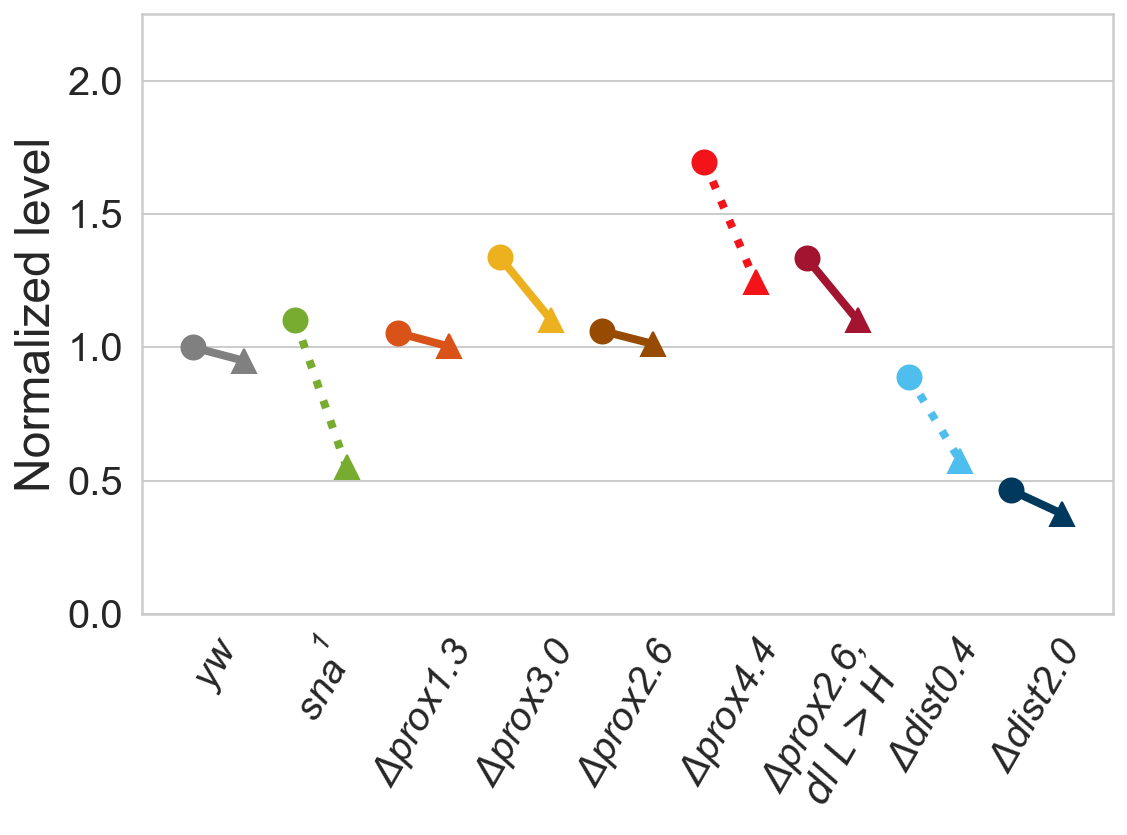

In [12]:
# Set up a figure with axes
fig, ax = plt.subplots(1, 1)

# Label the axes and title the plot
fig.set_size_inches(8, 6)

ind = [0,11,5,6,7,8,10,1,3]
ax.set_ylabel('Normalized level', fontsize=24)

ax.set_xlim([0,len(ind)*2+1])
ax.set_ylim([0,2.25])
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

j = 1
for i in range(len(ind)):
    ax.plot(j, sna[ind[i],-1,0]/sna[0,-1,0], 'o', label=labels[ind[i]], color=colors[ind[i]], markersize=12)
    ax.plot(j+1, sna[ind[i],-1,1]/sna[0,-1,0], '^', color=colors[ind[i]], markersize=12)
    # Full [11,8,1]
    # no repressor [0,11,5,6,7,8,10,1,3]
    # dist repressor [11,1]
    # cooperativity [11,6,8,10,1,3]
    if np.any(ind[i] == np.array([11,8,1])):
        ax.plot([j,j+1], [sna[ind[i],-1,0]/sna[0,-1,0],sna[ind[i],-1,1]/sna[0,-1,0]], ':', color=colors[ind[i]], linewidth=4)
    else:
        ax.plot([j,j+1], [sna[ind[i],-1,0]/sna[0,-1,0],sna[ind[i],-1,1]/sna[0,-1,0]], '-', color=colors[ind[i]], linewidth=4)
        
    j += 2

ax.set_xticks(np.arange(0,len(ind)*2,2)+1.5)
ax.set_xticklabels([labels[k] for k in ind], style='italic', rotation=60)
ax.grid(axis='x')
            
#plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=16);
#plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=32);
plt.tight_layout()
    
#plt.savefig('/Volumes/James McGehee Mac/Documents/Stathopoulos_Lab/Simulations/sna_reduced_cooperativity.pdf')

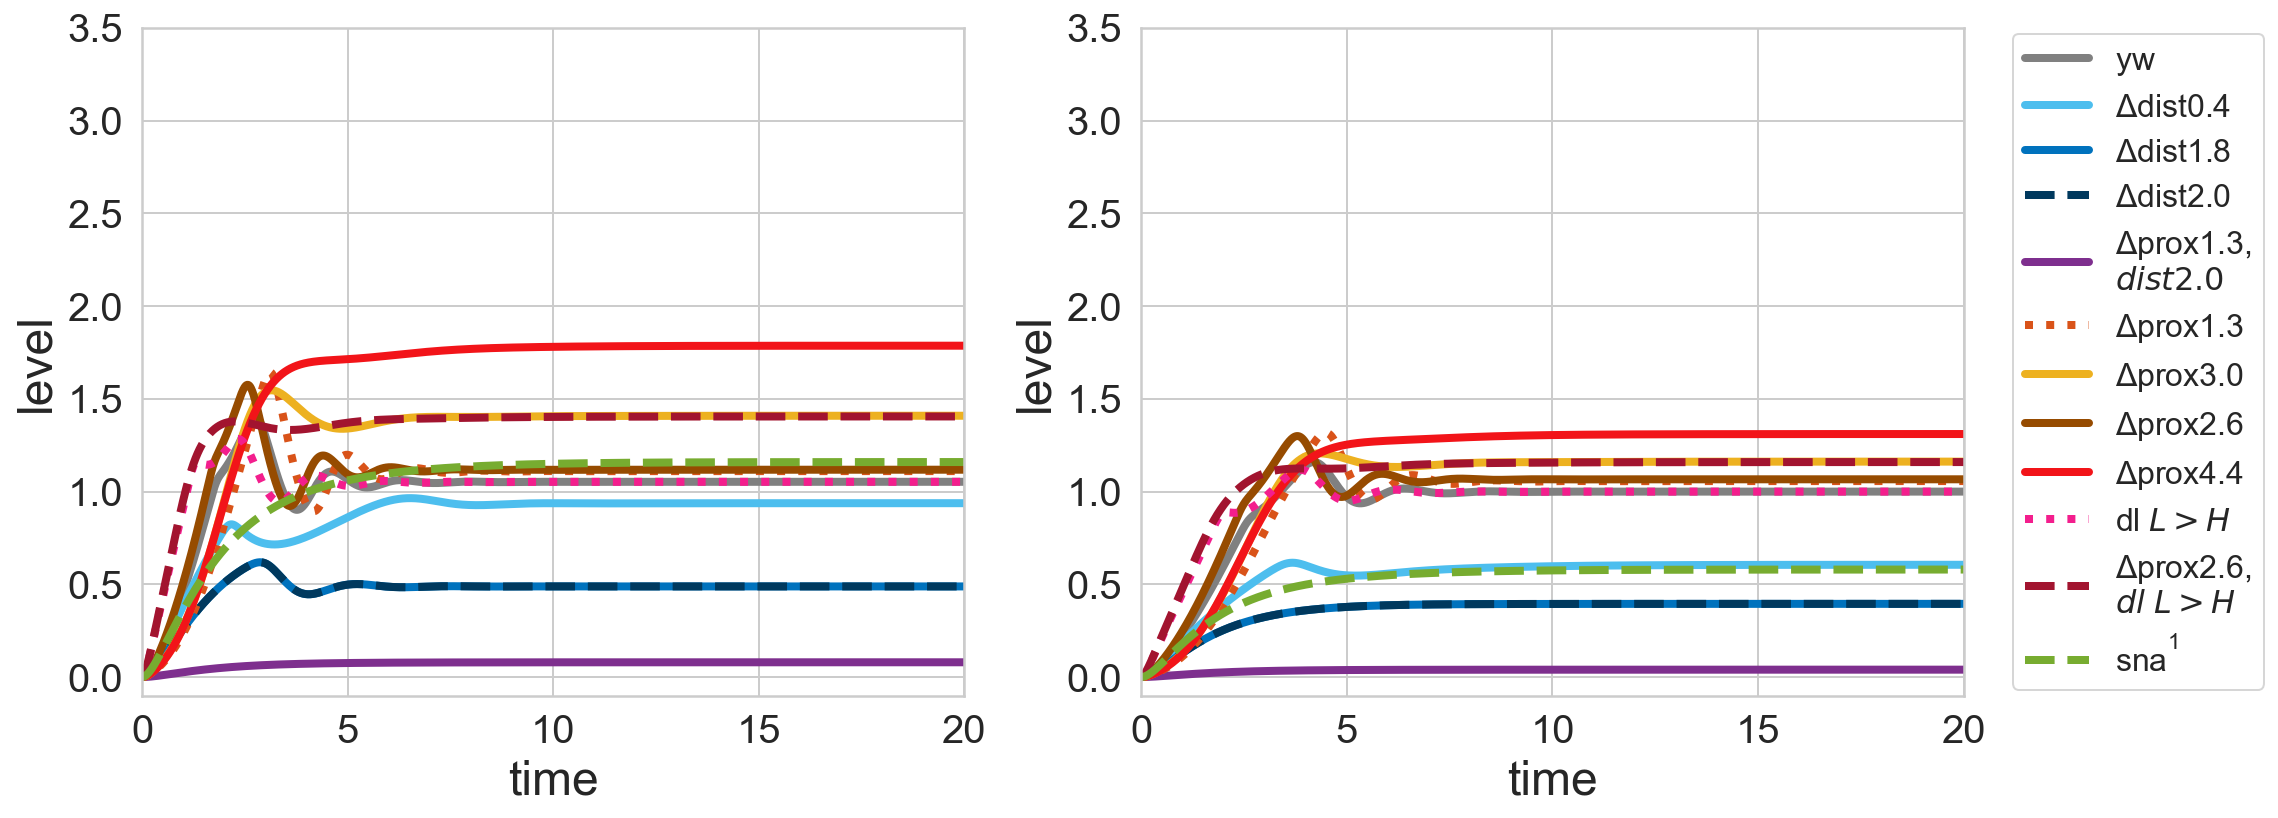

In [13]:
# Set up a figure with axes
fig, ax = plt.subplots(1, 2)

# Label the axes and title the plot
fig.set_size_inches(16, 6)

for j in range(2):
    ax[j].set_xlabel('time', fontsize=24)
    ax[j].set_ylabel('level', fontsize=24)
    ax[j].set_xlim([0,20])
    ax[j].set_ylim([-0.1,3.5])
    ax[j].tick_params(axis='x', labelsize=20)
    ax[j].tick_params(axis='y', labelsize=20)
    for i in range(n):
        # Make a plot
        if np.any(i == np.array([3, 10, 11])):
            ax[j].plot(t, sna[i,:,j], '--', label=labels[i], color=colors[i], linewidth=4)
        elif np.any(i == np.array([5, 9])):
            ax[j].plot(t, sna[i,:,j], ':', label=labels[i], color=colors[i], linewidth=4)
        else:
            ax[j].plot(t, sna[i,:,j], '-', label=labels[i], color=colors[i], linewidth=4)
            
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=16);
#plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, fontsize=32);
plt.tight_layout()
    
#plt.savefig('/Volumes/James McGehee Mac/Documents/Stathopoulos_Lab/Simulations/sna_time_model.pdf')

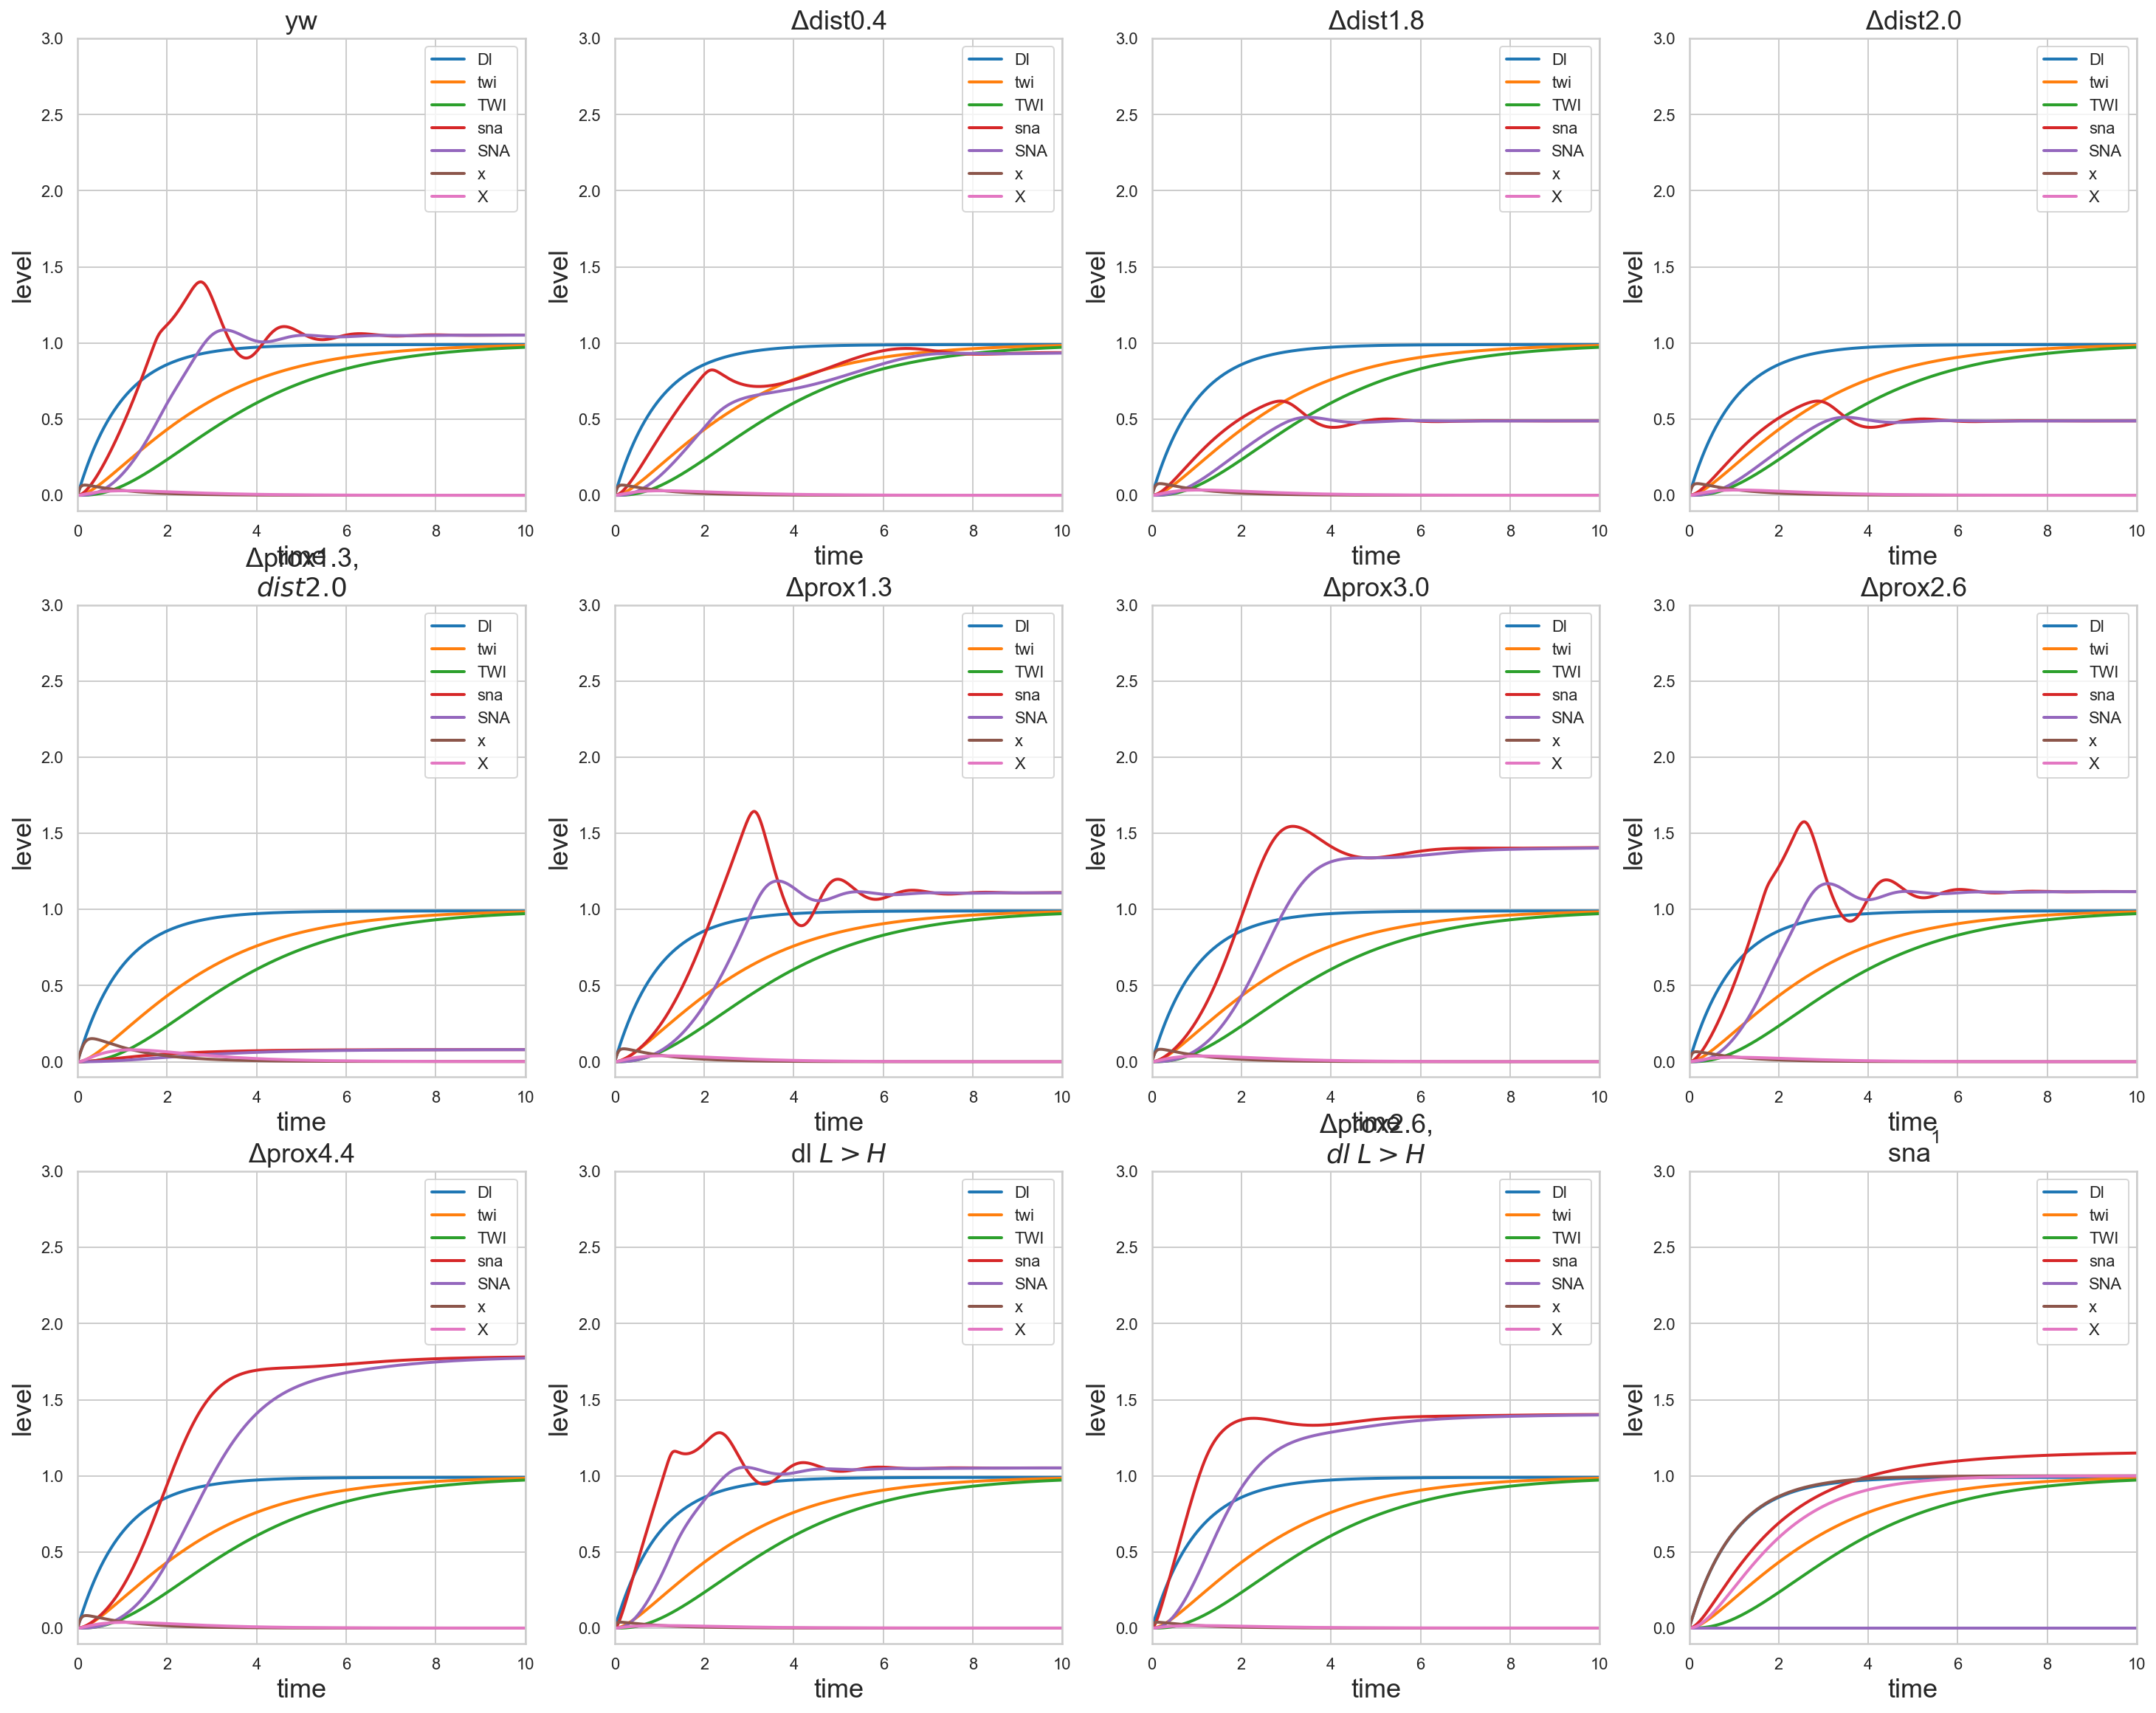

In [14]:
# Set up a figure with axes
fig, ax = plt.subplots(3, 4)

# Label the axes and title the plot
fig.set_size_inches(25, 20)

for i in range(n):
    j = int(np.floor(i/4))
    k = i % 4
    ax[j,k].set_xlabel('time')
    ax[j,k].set_ylabel('level')
    ax[j,k].set_xlim([0,10])
    ax[j,k].set_ylim([-0.1,3])

    # Make a scatter plot
    ax[j,k].plot(t, DL[i,:,0], label='Dl')
    ax[j,k].plot(t, twi[i,:,0], label='twi')
    ax[j,k].plot(t, TWI[i,:,0], label='TWI')
    ax[j,k].plot(t, sna[i,:,0], label='sna')
    ax[j,k].plot(t, SNA[i,:,0], label='SNA')
    ax[j,k].plot(t, x[i,:,0], label='x')
    ax[j,k].plot(t, X[i,:,0], label='X')
    ax[j,k].legend()
    ax[j,k].title.set_text(labels[i])